# Проэкт персонализации предложения постоянным клиентам для интернет-магазина "В один клик"

## Какова цель проекта?
Нашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.


## Исходные данные.

market_file.csv - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

market_money.csv - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

market_time.csv - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

money.csv - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.


## Содержание:
- 1. Загрузка данных
- 2. Предобработка данных
- 3. Исследовательский анализ данных
- 4. Объединение таблиц
- 5. Корреляционный анализ
- 6. Использование пайплайнов
- 7. Анализ важности признаков
- 8. Сегментация покупателей
- 9. Общий вывод

## 1. Загрузка данных

In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler #, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC





RANDOM_STATE = 42
TEST_SIZE = 0.25

In [2]:
market_file = pd.read_csv('/datasets/market_file.csv', sep=',')
market_money = pd.read_csv('/datasets/market_money.csv', sep=',')
market_time = pd.read_csv('/datasets/market_time.csv', sep=',')
money = pd.read_csv('/datasets/money.csv', sep=';')

In [3]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [4]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [5]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [6]:
money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


### Вывод: разделитель правильно скорректирован, все 4 таблицы загруженны

## 2. Предобработка данных

Проводим необходимую предобработку данных. Названия столбцов можно оставить кириллическими.

### market_file

In [7]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [8]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Формат колонок правильный, пропусков нет

In [9]:
duplicates = market_file.duplicated()
duplicated_rows = market_file[duplicates]
duplicated_rows.count()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

откровенных дупликатов нет, но стоит проверить колонку ID, потому что в будущем она будет использованна для джоинов.

In [10]:
market_file.nunique()

id                                     1300
Покупательская активность                 2
Тип сервиса                               3
Разрешить сообщать                        2
Маркет_актив_6_мес                       41
Маркет_актив_тек_мес                      3
Длительность                            658
Акционные_покупки                        42
Популярная_категория                      6
Средний_просмотр_категорий_за_визит       6
Неоплаченные_продукты_штук_квартал       11
Ошибка_сервиса                           10
Страниц_за_визит                         20
dtype: int64

у нас есть 1300 строк с 1300 уникальными ID

In [11]:
market_file['Тип сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [12]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace({
    'стандартт': 'стандарт'
})

In [13]:
market_file['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [14]:
market_file['Популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

### market_money

In [15]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [16]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [17]:
duplicates = market_money.duplicated()
duplicated_rows = market_money[duplicates]
duplicated_rows.count()

id         0
Период     0
Выручка    0
dtype: int64

In [18]:
market_money.nunique()

id         1300
Период        3
Выручка    2776
dtype: int64

In [19]:
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

стоит заметить что выручка за три периода. дубликатов откровенных нет, проблем с форматами тоже не видно

### market_time

In [20]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [21]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [22]:
duplicates = market_time.duplicated()
duplicated_rows = market_time[duplicates]
duplicated_rows.count()

id        0
Период    0
минут     0
dtype: int64

In [23]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [24]:
market_time.nunique()

id        1300
Период       2
минут       20
dtype: int64

Заметно что Периодов только 2. так же видно что есть ощибка в "предыдцщий_месяц" которую нужно исправить

In [25]:
market_time['Период'] = market_time['Период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')
market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

исправлена ошибка в колонке Период. в остальном проблем не видно

### money

In [26]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


In [27]:
money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


Видно что прибыль имеет не правельный формат

In [28]:
money['Прибыль'] = money['Прибыль'].str.replace(',', '.')
money['Прибыль'] = money['Прибыль'].astype(float)

In [29]:
duplicates = money.duplicated()
duplicated_rows = money[duplicates]
duplicated_rows.count()

id         0
Прибыль    0
dtype: int64

In [30]:
money.nunique()

id         1300
Прибыль     400
dtype: int64

пропусков нет, дубликатов нет

### Вывод

Дубликатов не обнаруженно

У нас есть 1300 уникальных ID, формат колонки везде одинаков - int64

Скорректирована колонка Период в одной из таблиц, так же исправлена ошибка в значениях и формате колонки Прибыль

## 3. Исследовательский анализ данных

### 1. Cтатистический анализ всех признаков market_file

ID можно игнорировать, там главное чтобюы не было дубликатов и формат

#### Маркет актив 6 мес	

In [31]:
market_file['Маркет_актив_6_мес'].describe()

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64

<AxesSubplot:>

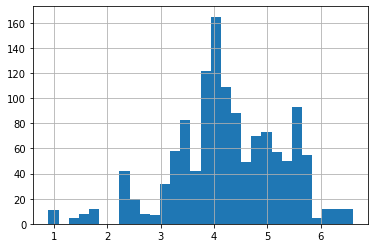

In [32]:
market_file['Маркет_актив_6_мес'].hist(bins=30)

Маркет_актив_6_мес: данные имеют нормальное распределение. без явных выбросов

#### Маркет_актив_тек_мес

In [33]:
market_file['Маркет_актив_тек_мес'].describe()


count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: Маркет_актив_тек_мес, dtype: float64

<AxesSubplot:>

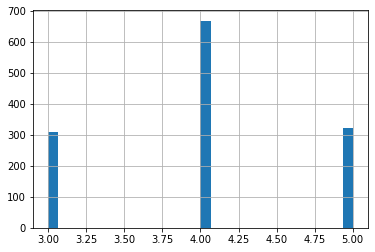

In [34]:
market_file['Маркет_актив_тек_мес'].hist(bins=30)

In [35]:
market_file['Маркет_актив_тек_мес'].unique()

array([5, 4, 3])

Маркет_актив_тек_мес: данные имеют нормальное распределение. стоит заметить что имеют только 3 значения

#### Длительность

In [36]:
market_file['Длительность'].describe()

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64

<AxesSubplot:>

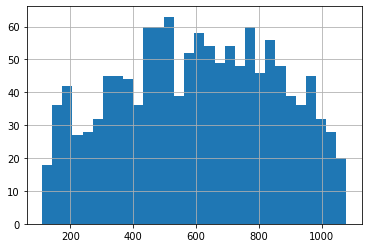

In [37]:
market_file['Длительность'].hist(bins=30)

Длительность: данные имеют нормальное распределение, но с возможным длинным хвостом.

#### Акционные_покупки

In [38]:
market_file['Акционные_покупки'].describe()

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64

<AxesSubplot:>

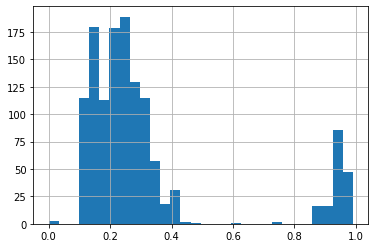

In [39]:
market_file['Акционные_покупки'].hist(bins=30)

Акционные_покупки: из графика видно что есть клиенты которые заходят купить лишь акционные товары

#### Средний_просмотр_категорий_за_визит

In [40]:
market_file['Средний_просмотр_категорий_за_визит'].describe()

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: Средний_просмотр_категорий_за_визит, dtype: float64

<AxesSubplot:>

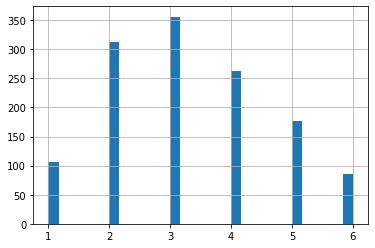

In [41]:
market_file['Средний_просмотр_категорий_за_визит'].hist(bins=30)

Средний_просмотр_категорий_за_визит: данные имеют нормальное распределение.

#### Неоплаченные_продукты_штук_квартал

In [42]:
market_file['Неоплаченные_продукты_штук_квартал'].describe()

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64

<AxesSubplot:>

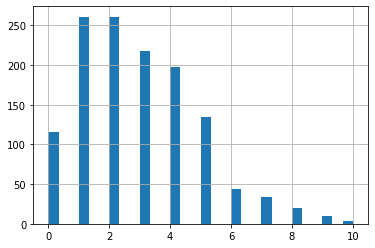

In [43]:
market_file['Неоплаченные_продукты_штук_квартал'].hist(bins=30)

Неоплаченные_продукты_штук_квартал: данные имеют нормальное распределение с хвостом в право

#### Ошибка_сервиса

In [44]:
market_file['Ошибка_сервиса'].describe()

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: Ошибка_сервиса, dtype: float64

<AxesSubplot:>

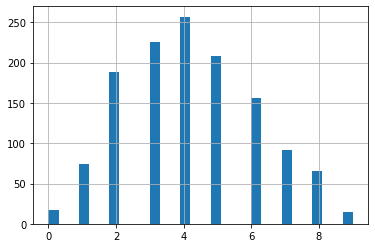

In [45]:
market_file['Ошибка_сервиса'].hist(bins=30)

Ошибка_сервиса: данные имеют нормальное распределение.

#### Страниц_за_визит

In [46]:
market_file['Страниц_за_визит'].describe()

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Страниц_за_визит, dtype: float64

<AxesSubplot:>

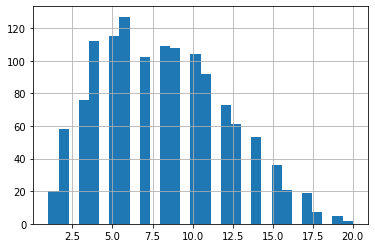

In [47]:
market_file['Страниц_за_визит'].hist(bins=30)

Страниц_за_визит: данные имеют нормальное распределение с хвостом в право

### 2. Cтатистический анализ всех признаков market_money

#### Выручка

In [48]:
market_money['Выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: Выручка, dtype: float64

<AxesSubplot:>

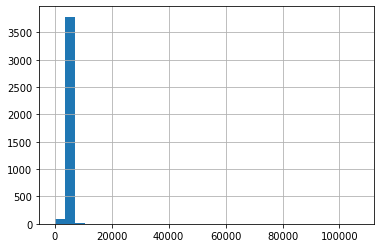

In [49]:
market_money['Выручка'].hist(bins=30)

Видно что есть аномальные данные которые придётся рассмотреть

In [50]:
market_money[market_money['Выручка'] > 8000]

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


придётся удалить эту строку данных потому что она создаёт слишком большой выброс

In [51]:
market_money = market_money[market_money['id'] != 215380]

In [52]:
market_money['Выручка'].describe()

count    3897.000000
mean     4999.287760
std       706.970089
min         0.000000
25%      4590.000000
50%      4956.000000
75%      5363.000000
max      7799.400000
Name: Выручка, dtype: float64

<AxesSubplot:>

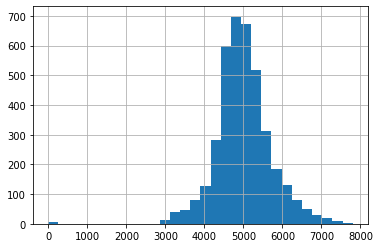

In [53]:
market_money['Выручка'].hist(bins=30)

In [54]:
market_money[market_money['Выручка'] < 2000]

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


удалим и нулевые значения

In [55]:
market_money = market_money[market_money['Выручка'] > 0]

<AxesSubplot:>

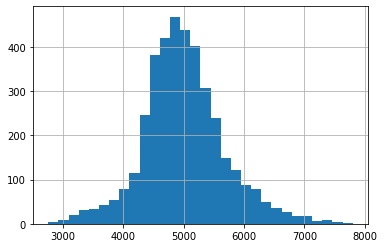

In [56]:
market_money['Выручка'].hist(bins=30)

In [57]:
market_money['Выручка'].describe()

count    3891.000000
mean     5006.996762
std       679.682828
min      2758.700000
25%      4591.900000
50%      4959.000000
75%      5363.000000
max      7799.400000
Name: Выручка, dtype: float64

получилось красивое нормальное распределение с которым можно будет работать

### 3. Cтатистический анализ всех признаков market_time

#### Минут

In [58]:
market_time['минут'].describe()

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

<AxesSubplot:>

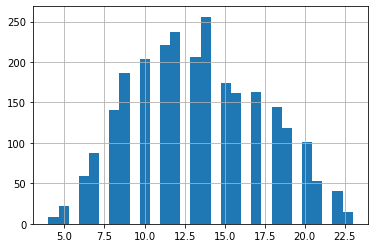

In [59]:
market_time['минут'].hist(bins=30)

нормальное распределение

### 4. Cтатистический анализ всех признаков money

#### Прибыль

In [60]:
money['Прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

<AxesSubplot:>

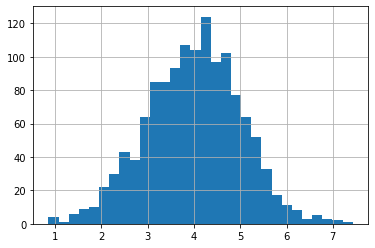

In [61]:
money['Прибыль'].hist(bins=30)

нормальное распределение

### Вывод

У большинства признаков нормальное распределение, в редких случаях присутствовал хвост в право

Были удалены 6 строк данных из market_money потому что имели в себе выбросы в колонке Выручка

## 4. Объединение таблиц

Считаю что вначале надо преобразить(пивот) данные из market_money и market_time, иначе джоин будет создавать дубликаты

### 1. Cоздания сводных таблиц

In [62]:
market_money

,id,Период,Выручка
1,215348,текущий_месяц,3293.1
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
...,...,...,...
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0


In [63]:
market_money_pivot = market_money.pivot(index='id', columns='Период', values='Выручка')

In [64]:
market_money_pivot.columns = ['Выручка_' + str(col) for col in market_money_pivot.columns]

In [65]:
market_money_pivot.head()

,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц
id,,,
215348,NaN,NaN,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [66]:
market_time_pivot = market_time.pivot(index='id', columns='Период', values='минут')

In [67]:
market_time_pivot.columns = ['Минут_' + str(col) for col in market_time_pivot.columns]

In [68]:
market_time_pivot.head()

,Минут_предыдущий_месяц,Минут_текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [69]:
market_time_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Минут_предыдущий_месяц  1300 non-null   int64
 1   Минут_текущий_месяц     1300 non-null   int64
dtypes: int64(2)
memory usage: 30.5 KB


In [70]:
market_money_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 215348 to 216647
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Выручка_предыдущий_месяц     1296 non-null   float64
 1   Выручка_препредыдущий_месяц  1296 non-null   float64
 2   Выручка_текущий_месяц        1299 non-null   float64
dtypes: float64(3)
memory usage: 40.6 KB


### 2. Объединение таблиц

In [71]:
merged_data = market_file.merge(market_money_pivot, on='id', how='inner').merge(market_time_pivot, on='id', how='inner')

In [72]:
merged_data.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [73]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 0 to 1298
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1299 non-null   int64  
 1   Покупательская активность            1299 non-null   object 
 2   Тип сервиса                          1299 non-null   object 
 3   Разрешить сообщать                   1299 non-null   object 
 4   Маркет_актив_6_мес                   1299 non-null   float64
 5   Маркет_актив_тек_мес                 1299 non-null   int64  
 6   Длительность                         1299 non-null   int64  
 7   Акционные_покупки                    1299 non-null   float64
 8   Популярная_категория                 1299 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1299 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1299 non-null   int64  
 11  Ошибка_сервиса                

### Вывод

Были созданы сводные таблицы

Обьеденены сводные таблицы и главная таблица. использовался метод соединения "иннер", потому что нам нужны данные только те где можно полностью соеденить

In [74]:
merged_data = merged_data.merge(money, on='id', how='inner')

In [75]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 0 to 1298
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1299 non-null   int64  
 1   Покупательская активность            1299 non-null   object 
 2   Тип сервиса                          1299 non-null   object 
 3   Разрешить сообщать                   1299 non-null   object 
 4   Маркет_актив_6_мес                   1299 non-null   float64
 5   Маркет_актив_тек_мес                 1299 non-null   int64  
 6   Длительность                         1299 non-null   int64  
 7   Акционные_покупки                    1299 non-null   float64
 8   Популярная_категория                 1299 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1299 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1299 non-null   int64  
 11  Ошибка_сервиса                

## 5. Корреляционный анализ

### 1. Изучите взаимосвязь между признаками: рассчитайте коэффициенты корреляции между всеми признаками

In [76]:
merged_data_no_id = merged_data.drop(['id', 'Прибыль'], axis=1)

In [77]:
merged_data_no_id.dropna()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц
1,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1295,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1296,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1297,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


по скольку данные зоть и распределены нормально но не являются непрерывнами то будет использован метод Spearman

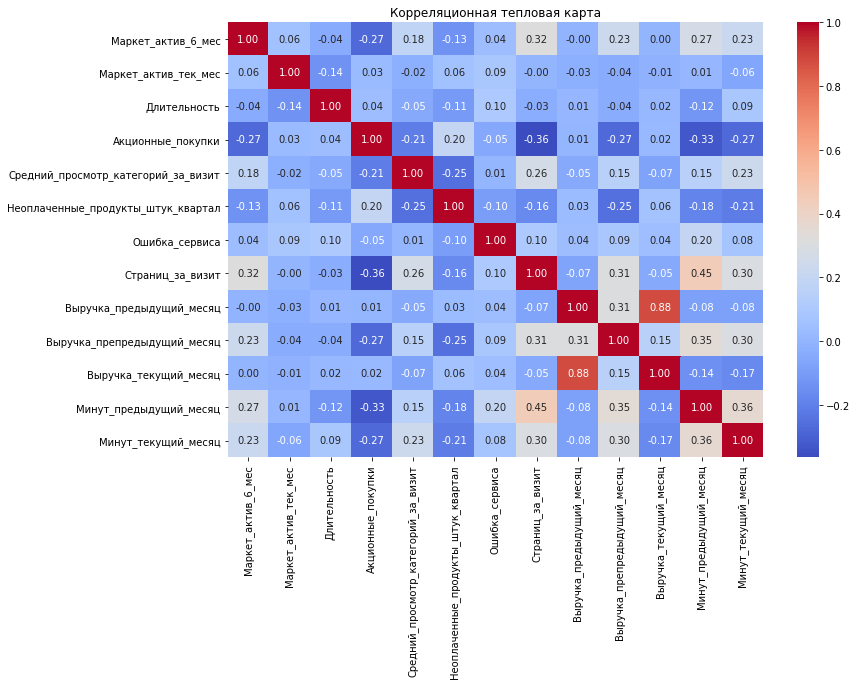

In [78]:
correlation_table = merged_data_no_id.corr(method='spearman')
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_table, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная тепловая карта')
plt.show()

In [79]:
correlation_long = correlation_table.stack().reset_index()
correlation_long.columns = ['Feature 1', 'Feature 2', 'Correlation']

high_corr = correlation_long[(correlation_long['Correlation'].abs() > 0.3) & (correlation_long['Feature 1'] != correlation_long['Feature 2'])]

high_corr = high_corr.assign(Pairs=high_corr.apply(lambda row: tuple(sorted([row['Feature 1'], row['Feature 2']])), axis=1))
high_corr = high_corr.drop_duplicates(subset='Pairs').drop(columns='Pairs')

high_corr = high_corr.reindex(high_corr['Correlation'].abs().sort_values(ascending=False).index)

high_corr

,Feature 1,Feature 2,Correlation
114,Выручка_предыдущий_месяц,Выручка_текущий_месяц,0.879097
102,Страниц_за_визит,Минут_предыдущий_месяц,0.450742
46,Акционные_покупки,Страниц_за_визит,-0.364675
155,Минут_предыдущий_месяц,Минут_текущий_месяц,0.360624
128,Выручка_препредыдущий_месяц,Минут_предыдущий_месяц,0.348745
50,Акционные_покупки,Минут_предыдущий_месяц,-0.330642
7,Маркет_актив_6_мес,Страниц_за_визит,0.319871
100,Страниц_за_визит,Выручка_препредыдущий_месяц,0.311675
113,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,0.308041


#### Факторы с наибольшей корреляцией

Выручка_предыдущий_месяц -> Выручка_текущий_месяц corr = 0.879097

Страниц_за_визит -> Минут_предыдущий_месяц corr = 0.45076

Акционные_покупки -> Страниц_за_визит corr = -0.37086

Минут_предыдущий_месяц -> Минут_текущий_месяц corr = 0.360471

Выручка_препредыдущий_месяц -> Минут_предыдущий_месяц corr = 0.348745

Акционные_покупки -> Минут_предыдущий_месяц corr = -0.332548

Маркет_актив_6_мес -> Страниц_за_визит corr = 0.319872

Страниц_за_визит -> Выручка_препредыдущий_месяц corr = 0.311675

Выручка_предыдущий_месяц -> Выручка_препредыдущий_месяц corr = 0.308041

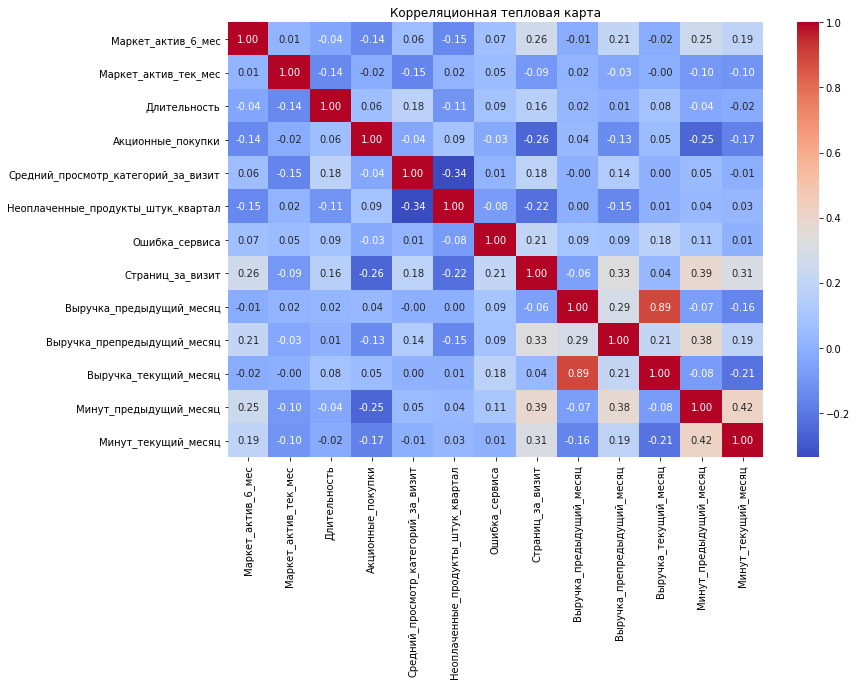

In [80]:
correlation_table = merged_data_no_id[merged_data_no_id['Покупательская активность'] == 'Снизилась'].corr(method='spearman')
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_table, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная тепловая карта')
plt.show()

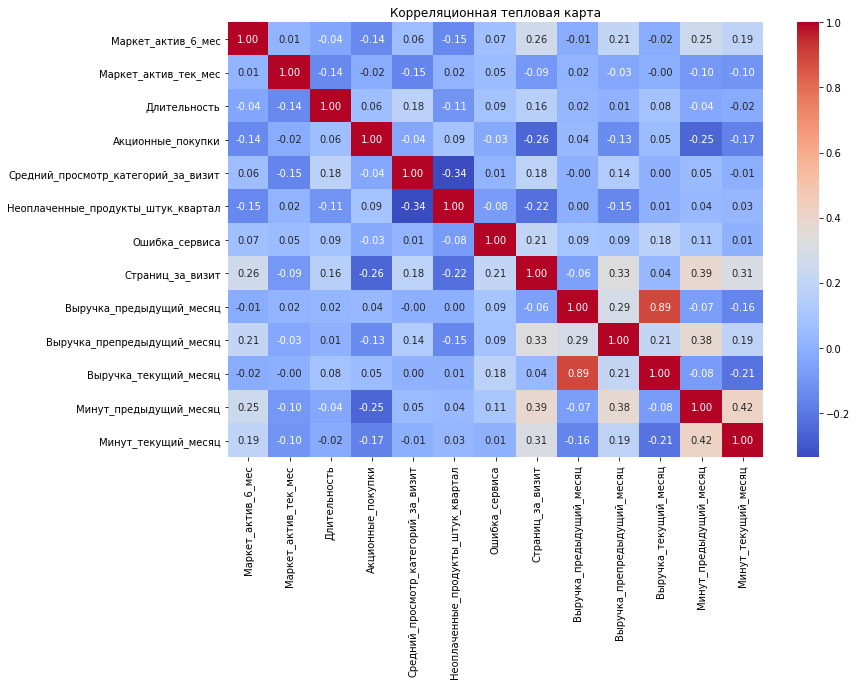

In [81]:
correlation_table = merged_data_no_id[merged_data_no_id['Покупательская активность'] != 'Прежний уровень'].corr(method='spearman')
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_table, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная тепловая карта')
plt.show()

### 2. графики для каждого числового признака

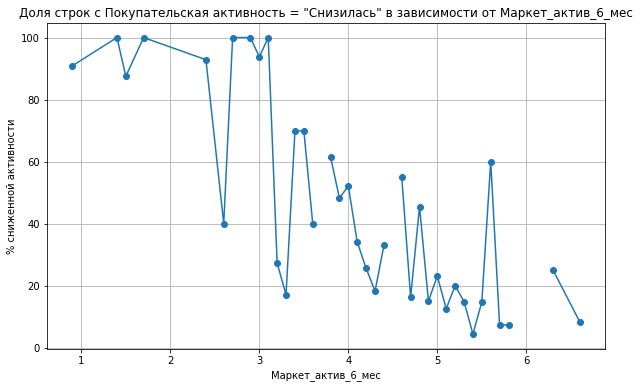

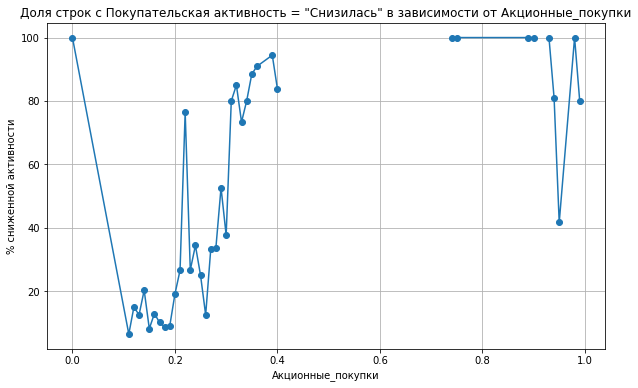

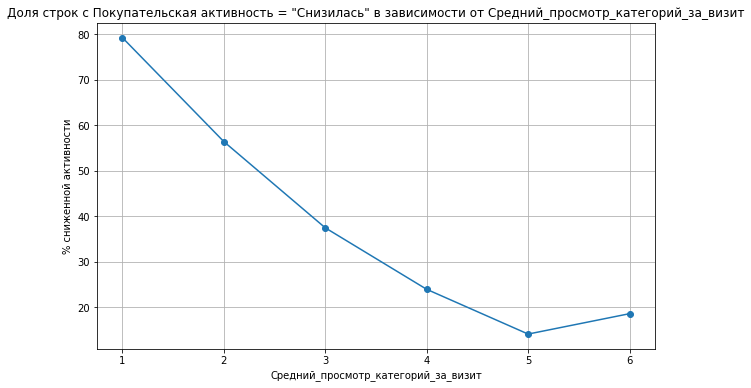

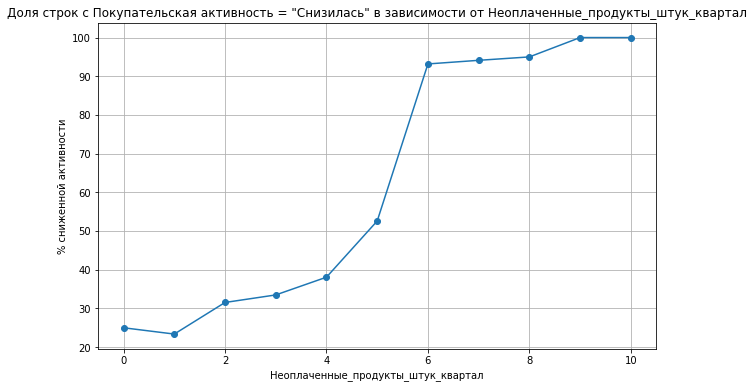

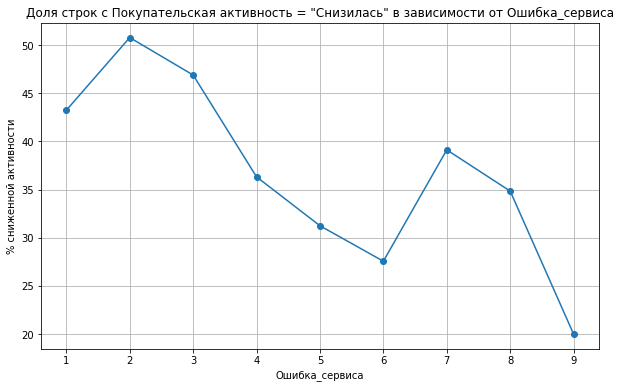

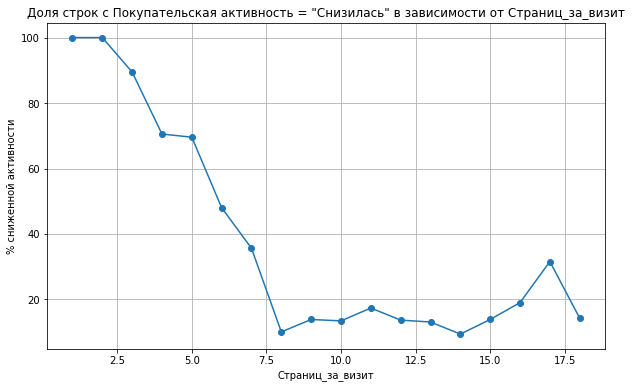

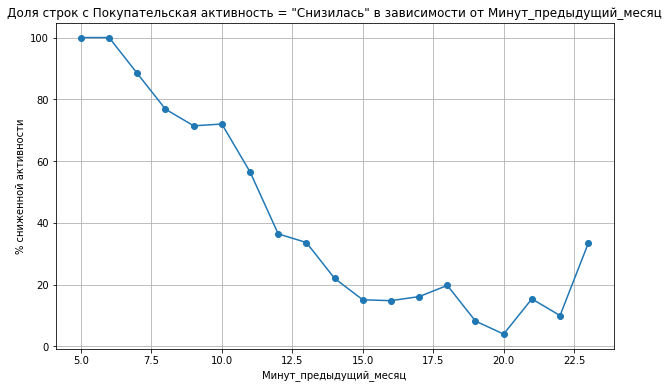

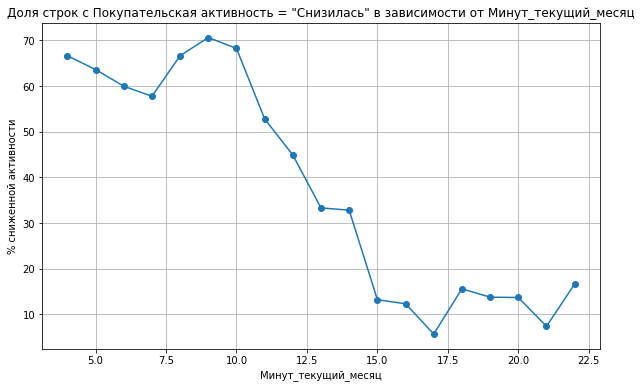

In [82]:
def plot_slowed_activity_proportion(data, numeric_columns):
    for column in numeric_columns:
        count_slowed_activity = data[data['Покупательская активность'] == 'Снизилась'].groupby(column).size()
        total_count = data.groupby(column).size()
        proportion_slowed_activity = (count_slowed_activity / total_count) * 100  

        plt.figure(figsize=(10, 6))
        plt.plot(proportion_slowed_activity.index, proportion_slowed_activity.values, marker='o')
        plt.xlabel(column)
        plt.ylabel('% сниженной активности')
        plt.title(f'Доля строк с Покупательская активность = "Снизилась" в зависимости от {column}')
        plt.grid(True)
        plt.show()


merged_data_graphs = merged_data_no_id.drop(columns=['Длительность', 'Выручка_препредыдущий_месяц', 'Маркет_актив_тек_мес', 'Выручка_текущий_месяц', 'Выручка_предыдущий_месяц'])        
        
numeric_columns = merged_data_graphs.select_dtypes(include=['number']).columns


plot_slowed_activity_proportion(merged_data_graphs, numeric_columns)

#### Интересные наблюдения

Маркет_актив_6_мес - чем больше маркетинговой активности тем менше % сниженой активности

Маркет_актив_тек_мес - разница не большая и странно что 4 имеет ниже значение чем 3. Возможно 4 маркетинг был не правильным

Акционные покупки - заметно что самые низкие показатели снидения активности находятся в районе 0.1-0.2. Возможно это связанно с тем что люди просто призодят купить продукты по акции и больше к нам не возвращаются

Средний_просмотр_категорий_за_визит - чем меньше категорий клиент просматривает тем больще шанс снижения активности

Неоплаченные_продукты_штук_кваратл - чем больше неоплаченных продуктов тем больше снижение активности

Ошибка_сервиса - чем больше сбоев сервисса тем выше активность покупателя? На первый взгляд странно. но покупателем который получит больше всего сбоев будет тот кто наверное самый активный. Человек который не пользуется интернетом не будет знать о его сбоях

Страниц_за_визит - чем больше страниц тем меньше снижения актиности. Странное повышение снижения на 16-17 страницах

Минут_предыдущий_месяц - чем больше минут проводять на сайте тем меньше снижение активности. Логично

### Вывод

Были выявлены факторы с наибоьшей корреляцией

Так же были интересные наблюдения из графиков используя % Снижения

## 6. Использование пайплайнов


Следует удалить НаН

In [83]:
merged_data_no_id.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 0 to 1298
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1299 non-null   object 
 1   Тип сервиса                          1299 non-null   object 
 2   Разрешить сообщать                   1299 non-null   object 
 3   Маркет_актив_6_мес                   1299 non-null   float64
 4   Маркет_актив_тек_мес                 1299 non-null   int64  
 5   Длительность                         1299 non-null   int64  
 6   Акционные_покупки                    1299 non-null   float64
 7   Популярная_категория                 1299 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1299 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1299 non-null   int64  
 10  Ошибка_сервиса                       1299 non-null   int64  
 11  Страниц_за_визит              

In [84]:
df_full_clean = merged_data_no_id

In [85]:
df_full_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 0 to 1298
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1299 non-null   object 
 1   Тип сервиса                          1299 non-null   object 
 2   Разрешить сообщать                   1299 non-null   object 
 3   Маркет_актив_6_мес                   1299 non-null   float64
 4   Маркет_актив_тек_мес                 1299 non-null   int64  
 5   Длительность                         1299 non-null   int64  
 6   Акционные_покупки                    1299 non-null   float64
 7   Популярная_категория                 1299 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1299 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1299 non-null   int64  
 10  Ошибка_сервиса                       1299 non-null   int64  
 11  Страниц_за_визит              

### Создание пайплайна

In [86]:
# Разделение данных
X = df_full_clean.drop(['Покупательская активность'], axis=1)
y = df_full_clean['Покупательская активность'].apply(lambda x: 1 if x == 'Снизилась' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Колонки
ohe_columns = ['Тип сервиса', 'Популярная_категория']
ord_columns = ['Разрешить сообщать']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки',
               'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 
               'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_предыдущий_месяц', 
               'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц', 'Минут_предыдущий_месяц', 'Минут_текущий_месяц']

# Пайплайны
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='error', sparse=False, drop='first'))
])

ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=[['нет', 'да']], handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

num_pipe = Pipeline([
    ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler())
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', num_pipe, num_columns)
], remainder='passthrough')

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

### Сетка параметров для RandomizedSearchCV

In [87]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': [0.01, 0.1, 1, 10, 100],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],  
        'models__C': [0.01, 0.1, 1, 10, 100],
        'models__kernel': ['linear', 'rbf'],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

### Настройка RandomizedSearchCV

In [88]:
randomized_search = RandomizedSearchCV(pipe_final, param_grid, cv=5, scoring='roc_auc', random_state=RANDOM_STATE, n_jobs=-1)
randomized_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse=False))]),
                                                                               ['Тип '
                                         

### Результаты


In [89]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_proba = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Тип сервиса',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                          

### Вывод

Выбор модели: 

Лучшей моделью в данном случае оказался SVC с параметром C=10.

Метрики:

Высокое значение ROC-AUC на тренировочных данных (0.900) указывает на то, что модель очень хорошо подогнана под тренировочные данные.
Высокое значение ROC-AUC, такое как 0.914, указывает на то, что модель очень хорошо отличает положительные классы от отрицательных

## 7. Анализ важности признаков

### 1. Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP. 

Поскольку выбрана модель SVC то приходиться использовать KernelExplainer. Она занимвет слишком много времяни чтобы запускаться на всех данных поэтому была создана подвыборка 20

  0%|          | 0/20 [00:00<?, ?it/s]

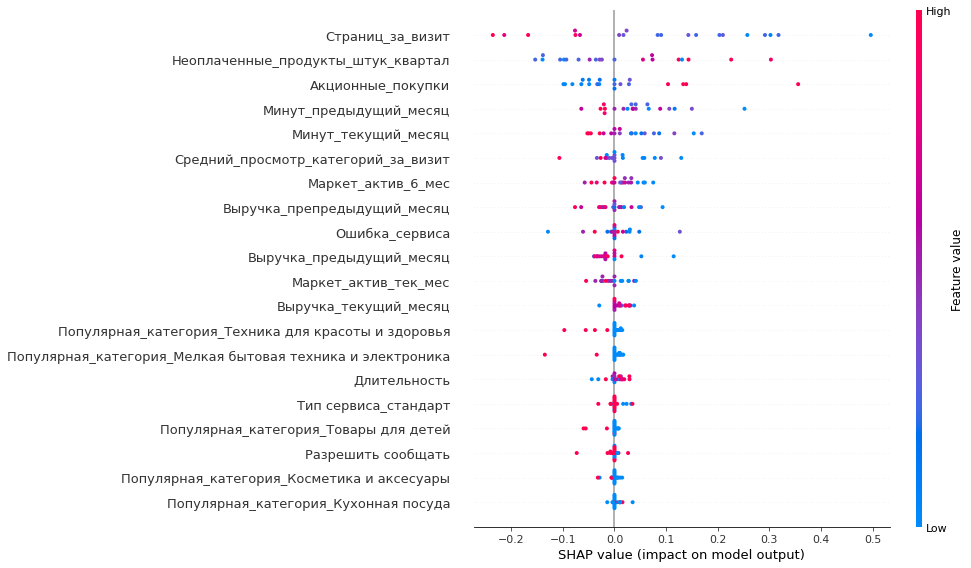

In [90]:
best_model_pipeline = randomized_search.best_estimator_

preprocessor = best_model_pipeline.named_steps['preprocessor']
model = best_model_pipeline.named_steps['models']

# достаем названия фич
ohe_feature_names = preprocessor.named_transformers_['ohe'].named_steps['ohe'].get_feature_names(ohe_columns)
# склеиваем их в один массив
col_names = np.concatenate([ohe_feature_names, ord_columns, num_columns])

# создаём датафреймы из стандартизированных массивов
X_train_transformed = pd.DataFrame(preprocessor.transform(X_train), columns=col_names)
X_test_transformed = pd.DataFrame(preprocessor.transform(X_test), columns=col_names)

# берём подвыборки
subset_size = 20  

X_train_transformed = shap.sample(X_train_transformed, subset_size, random_state=42)
X_test_transformed = shap.sample(X_test_transformed, subset_size, random_state=42)

# создаем explainer
explainer = shap.KernelExplainer(model.predict, X_train_transformed)

# вычисляем значения shap
shap_values = explainer.shap_values(X_test_transformed)
# строим график важности признаков
shap.summary_plot(shap_values, X_test_transformed, plot_size=(14, 8))

Из любопытства рассмотрим Waterfall для одного наблюдения

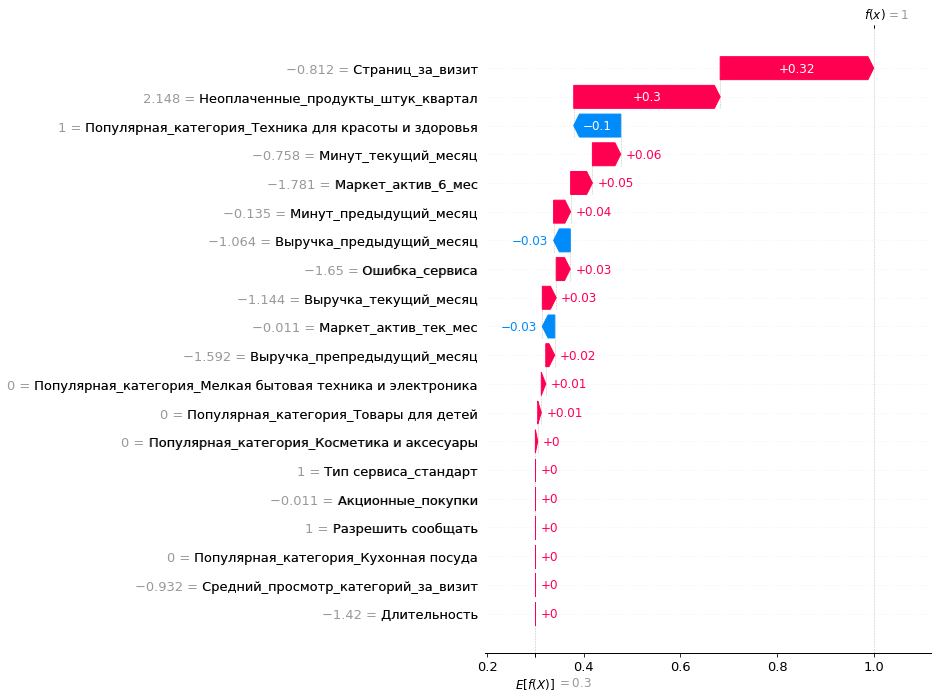

In [91]:
index = 0  
shap.waterfall_plot(shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, data=X_test_transformed.iloc[index]), max_display=20)
plt.show()

Заметно что главне факторы остались примерно теми же, но не совсем в том же порядке

### Вывод

10 Самых влияющих факторов на модель:

Страниц_за_визит: Высокие значения имеют отрицательное влияние на предсказания. Низкие значения в основном оказывают положительное влияние.

Минут_предыдущий_месяц: Высокие значения в основном уменьшают предсказания, низкие значения увеличивают предсказания.

Акционные_покупки: Высокие значения в основном увеличивают предсказания, низкие значения оказывают меньшее влияние.

Неоплаченные_продукты_штук_квартал: Высокие значения в основном увеличивают предсказания модели.

Минут_текущий_месяц: Высокие значения уменьшают предсказания, низкие значения увеличивают предсказания.

Маркет_актив_6_мес: Высокие значения оказывают как положительное, так и отрицательное влияние на предсказания.

Выручка_препредыдущий_месяц: Высокие значения уменьшают предсказания, низкие значения увеличивают предсказания.

Средний_просмотр_категорий_за_визит: Высокие значения уменьшают предсказания, низкие значения увеличивают предсказания.

Выручка_предыдущий_месяц: Высокие значения уменьшают предсказания, низкие значения увеличивают предсказания.

Длительность: Высокие значения оказывают как положительное, так и отрицательное влияние на предсказания.

## 8. Сегментация покупателей

### 1. Для начала нужно будет создать таблицу с вероятностями снижения покупательской активности, соединить её с данными прибыли и с основной таблицей

In [92]:
probabilities = randomized_search.predict_proba(X_test)[:, 1]

In [93]:
prob_df = pd.DataFrame(probabilities, columns=['Вероятность_снижения_активности'])
prob_df['original_index'] = X_test.index

In [94]:
merged_data['original_index'] = merged_data.index

In [95]:
merged_data_with_prob = merged_data.merge(prob_df, on='original_index', how='inner')

In [96]:
merged_data_with_prob = merged_data_with_prob.drop('original_index', axis=1)

In [97]:
merged_data_with_prob.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 0 to 259
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   260 non-null    int64  
 1   Покупательская активность            260 non-null    object 
 2   Тип сервиса                          260 non-null    object 
 3   Разрешить сообщать                   260 non-null    object 
 4   Маркет_актив_6_мес                   260 non-null    float64
 5   Маркет_актив_тек_мес                 260 non-null    int64  
 6   Длительность                         260 non-null    int64  
 7   Акционные_покупки                    260 non-null    float64
 8   Популярная_категория                 260 non-null    object 
 9   Средний_просмотр_категорий_за_визит  260 non-null    int64  
 10  Неоплаченные_продукты_штук_квартал   260 non-null    int64  
 11  Ошибка_сервиса                  

### 2. Выбрать сегмент покупателей

Ранее уже было замеченно что есть покупатели у которых преобладают акционные покупки а так же замеченно что активность клиентов снижалась . смотрим как выглядят данные этой выборки

In [98]:
merged_data_with_prob['Акционные_покупки'].nunique()

38

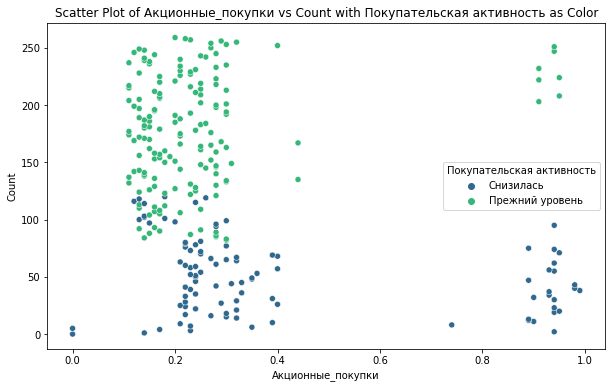

In [99]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=merged_data_with_prob,
    x='Акционные_покупки',
    y=merged_data_with_prob.index,
    hue='Покупательская активность',
    palette='viridis'
)

plt.title('Scatter Plot of Акционные_покупки vs Count with Покупательская активность as Color')
plt.xlabel('Акционные_покупки')
plt.ylabel('Count')
plt.show()

Исходя из этого можно провесте сегментацию "Высокая доля акций" и "Низкая доля акций" с возможным разделением между 0.5 и 0.7. Я предлагаю выбрать 0.6

In [100]:
merged_data_with_prob['discount_prop_cat_segm'] = np.where(merged_data_with_prob['Акционные_покупки'] > 0.6, 'Высокая доля акций', 'Низкая доля акций')

### 3.  Фокусирование на Высокой доли акций

In [101]:
focus_data = merged_data_with_prob[merged_data_with_prob['discount_prop_cat_segm'] == 'Высокая доля акций']

создам дополниетьльный признак "activity_pred"

In [104]:
focus_data['activity_pred'] = np.where(focus_data['Вероятность_снижения_активности'] > 0.5, 'Потеря', 'Лояльный')

/tmp/ipykernel_269/4071167434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focus_data['activity_pred'] = np.where(focus_data['Вероятность_снижения_активности'] > 0.5, 'Потеря', 'Лояльный')


In [113]:
focus_data.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,...,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц,Прибыль,Вероятность_снижения_активности,discount_prop_cat_segm,activity_pred
2,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,...,2,5807.5,4594.0,5872.5,8,11,4.21,0.910560,Высокая доля акций,Потеря
8,215362,Снизилась,премиум,да,4.2,4,438,0.74,Домашний текстиль,3,...,4,4314.0,4765.0,4447.9,13,13,3.49,0.847559,Высокая доля акций,Потеря
11,215373,Снизилась,премиум,нет,3.8,3,811,0.90,Товары для детей,2,...,3,4632.0,4293.0,5161.1,10,8,3.69,0.990671,Высокая доля акций,Потеря
12,215375,Снизилась,премиум,да,3.0,4,558,0.89,Товары для детей,3,...,4,5253.5,4715.0,5633.1,8,9,4.18,0.977841,Высокая доля акций,Потеря
13,215382,Снизилась,стандарт,да,4.6,4,330,0.89,Техника для красоты и здоровья,6,...,6,5545.5,4824.0,6403.5,15,8,2.42,0.405552,Высокая доля акций,Лояльный


#### Статистические различия

In [110]:
focus_data_lower = focus_data[focus_data['Покупательская активность'] == 'Снизилась']
focus_data_same = focus_data[focus_data['Покупательская активность'] == 'Прежний уровень']

In [111]:
focus_data_lower.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц,Прибыль,Вероятность_снижения_активности
count,24.000000,24.000000,24.00000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.00000,24.000000
mean,215525.041667,3.875000,4.00000,622.125000,0.925417,2.666667,4.750000,4.916667,4.416667,5017.458333,4600.458333,5385.629167,10.625000,10.750000,3.80875,0.869200
std,147.032525,0.851725,0.65938,223.041098,0.048632,1.090140,2.608514,1.931808,2.733316,757.250761,254.495576,959.854607,2.901461,3.110291,0.86695,0.177420
min,215352.000000,1.400000,3.00000,249.000000,0.740000,1.000000,1.000000,1.000000,2.000000,3441.000000,4119.000000,3520.300000,6.000000,6.000000,2.41000,0.271358
25%,215407.750000,3.725000,4.00000,466.250000,0.900000,2.000000,2.750000,3.750000,3.000000,4630.625000,4415.250000,5013.475000,8.000000,8.000000,3.36750,0.876404
50%,215487.000000,4.000000,4.00000,557.500000,0.940000,2.500000,4.500000,5.000000,3.500000,5158.000000,4570.500000,5543.850000,11.000000,10.000000,3.69500,0.911654
75%,215596.500000,4.250000,4.00000,802.750000,0.942500,3.000000,6.250000,7.000000,5.000000,5351.375000,4785.000000,5882.175000,12.250000,13.000000,4.26250,0.978175
max,215910.000000,5.500000,5.00000,1064.000000,0.990000,6.000000,10.000000,8.000000,14.000000,6716.500000,5204.000000,7799.400000,18.000000,19.000000,5.79000,0.990671


In [112]:
focus_data_same.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц,Прибыль,Вероятность_снижения_активности
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,216475.285714,4.642857,4.142857,521.000000,0.930000,3.714286,2.714286,3.000000,9.571429,4893.142857,5044.714286,5245.071429,14.142857,15.428571,3.934286,0.369614
std,85.972310,0.810056,0.690066,287.598679,0.019149,1.799471,2.288689,1.914854,3.598942,313.574116,270.145463,414.074743,2.734262,5.912054,1.397031,0.210494
min,216356.000000,3.700000,3.000000,237.000000,0.910000,1.000000,0.000000,0.000000,4.000000,4602.000000,4522.000000,4766.200000,9.000000,6.000000,1.570000,0.064682
25%,216422.500000,4.000000,4.000000,303.500000,0.910000,2.500000,1.500000,2.000000,7.500000,4720.000000,4963.500000,5025.500000,13.500000,12.000000,3.175000,0.199634
50%,216460.000000,4.400000,4.000000,433.000000,0.940000,4.000000,2.000000,3.000000,10.000000,4766.500000,5160.000000,5230.700000,15.000000,17.000000,4.280000,0.474323
75%,216535.500000,5.400000,4.500000,674.000000,0.945000,5.000000,3.500000,4.500000,11.500000,4950.500000,5217.500000,5298.000000,15.000000,19.500000,4.880000,0.528032
max,216595.000000,5.600000,5.000000,1022.000000,0.950000,6.000000,7.000000,5.000000,15.000000,5542.500000,5269.000000,6071.600000,18.000000,22.000000,5.580000,0.592961


Что видно интересного:

Средний просмотр категорий за визит - у лояльных клиентов он в среднем значительно выше 3.7 против 2.6

Неоплаченные_продукты_штук_квартал - у лояльных клиентов в среднем значительно меньше 2.7 против 4.8

Ошибка сервиса - у лояльных клиентов в среднем значительно меньше 3 против 4.9

Страниц за визит - у лояльных 9.6 против 4.4

Прибыль примерно одинакова, однако выручка у лояльных клиентов меньше, как в текущем так и в прошлом месяце.

#### Рассмотрим категориальные столбцы

In [114]:
categorical_fields = ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']

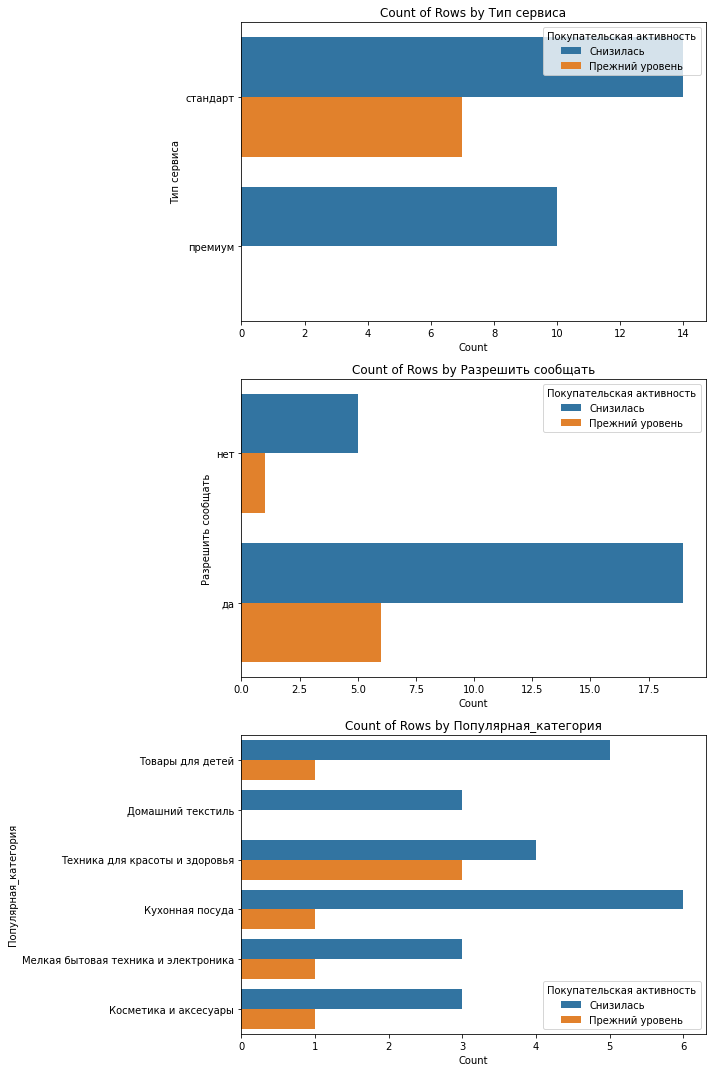

In [121]:
# Create a figure for the subplots
fig, axes = plt.subplots(len(categorical_fields), 1, figsize=(10, len(categorical_fields) * 5))

# Plot each categorical field
for i, field in enumerate(categorical_fields):
    sns.countplot(data=focus_data, y=field, hue='Покупательская активность', ax=axes[i])
    axes[i].set_title(f'Count of Rows by {field}')
    axes[i].set_ylabel(field)
    axes[i].set_xlabel('Count')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

Заметно что из клиентов которые фокусируются на акционных продуктах:

Тип сервиса - Премиум снижает активность

Разрешить сообщать -не сильно влияет на активность но большнство отметили "ДА"

Самые популярные категории - Кухонная посуда, Техника для красоты и здоровья, Товары для детей

### Вывод и предложения:

Лояльные клиенты, которые покупают акционные продукты и у которых не снижается активность:

Не являются "Премиум" клиентами

больше аремяни проводят на сайте и листают больше категорий

испытывают меньше проблем с сервисом 

предпочитают покупать продукты из категории Техника для красоты и здоровья.



Предложения:

Узнать что входит в Премиум сервис. Возможно туда входит рассылка на электронную почту с сылкой на скидочные товары

Узнать почему клиенты со сниженной активностью испытали так много перебоев с сервисом

Кухонная посуда и Товары для детей это популярные категории и возможно стоит почаще делать на них маркетинг чтобы повысить активность?

## 9. Общий вывод

### Задача

разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

### Исходные данные и предобработка

Нам было предоставленно 4 файла:

market_file.csv - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

market_money.csv - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом

market_time.csv - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

money.csv - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

В них содержалась информация о 1300 клиентах. Данные были проверенны на наличие пропусков, выбросом и дубликатов. Так же были проведенны статистические анализы данных

### Что было сделанно для поиска лучшей модели

Данные были соеденены и удалены не нужные признаки

Был создан пайплайн

Было обученно 4 модели и сравнены между собой

Была выбранна лучшая модель

### Лучшая Модель

SVC(C=10, probability=True, random_state=42))])

Метрика лучшей модели на тренировочной выборке: 0.9041933369517221

Метрика ROC-AUC на тестовой выборке: 0.9132316958403915

### Сегмент покупателей "Акционный"

Было установленно что есть сегмент покупателей которые "охотятся" на акции. Среди них большинство покупателей со сниженной активностью

Следует рассмотреть что в себя включает премиум аккаунт, потому что подозреваю что там будет рассылка на акции

Стоит снизить колчество неоплаченных продуктов в карзине, возможно клиенты забывают и им стоит напомнить?

Рассмотреть в чем разница между категориями Техника для красоты и здровья, Кухонная посуда и Товары для детей. Потому что в Техника для красоты и здровья гораздо больще соотношение лояльных клиентов

Устранить перебои в системе